## 와인 등급 분류 모델 구현
- 데이터 : CSV
- 피 처 : 11개
- 타 겟 : 정수값

In [1]:
import pandas as pd                                  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
data_file = '../DATA/winequality-white.csv'

In [3]:
whitewineDF = pd.read_csv(data_file, sep = ';')
whitewineDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
whitewineDF.shape

(4898, 12)

In [5]:
whitewineDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [6]:
# 중복 데이터 제거
whitewineDF = whitewineDF.drop_duplicates()
whitewineDF.shape

(3961, 12)

In [7]:
# 결측치 없음
whitewineDF.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### 데이터 전처리 <hr>

#### 이상치 처리

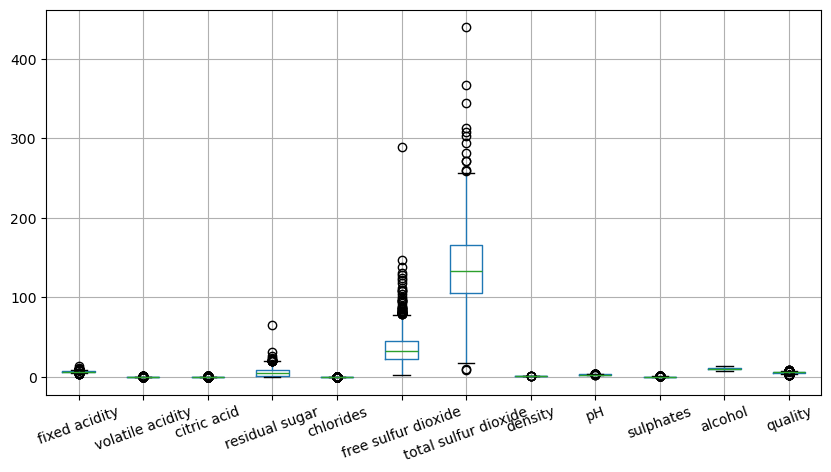

In [8]:
whitewineDF.boxplot(figsize = (10, 5), rot = 20)
plt.show()

In [9]:
whitewineDF.nunique()  # nunique 함수는 dropna 매개변수 default값이 True이므로 결측값은 제외한다.

fixed acidity            68
volatile acidity        125
citric acid              87
residual sugar          310
chlorides               160
free sulfur dioxide     132
total sulfur dioxide    251
density                 890
pH                      103
sulphates                79
alcohol                 103
quality                   7
dtype: int64

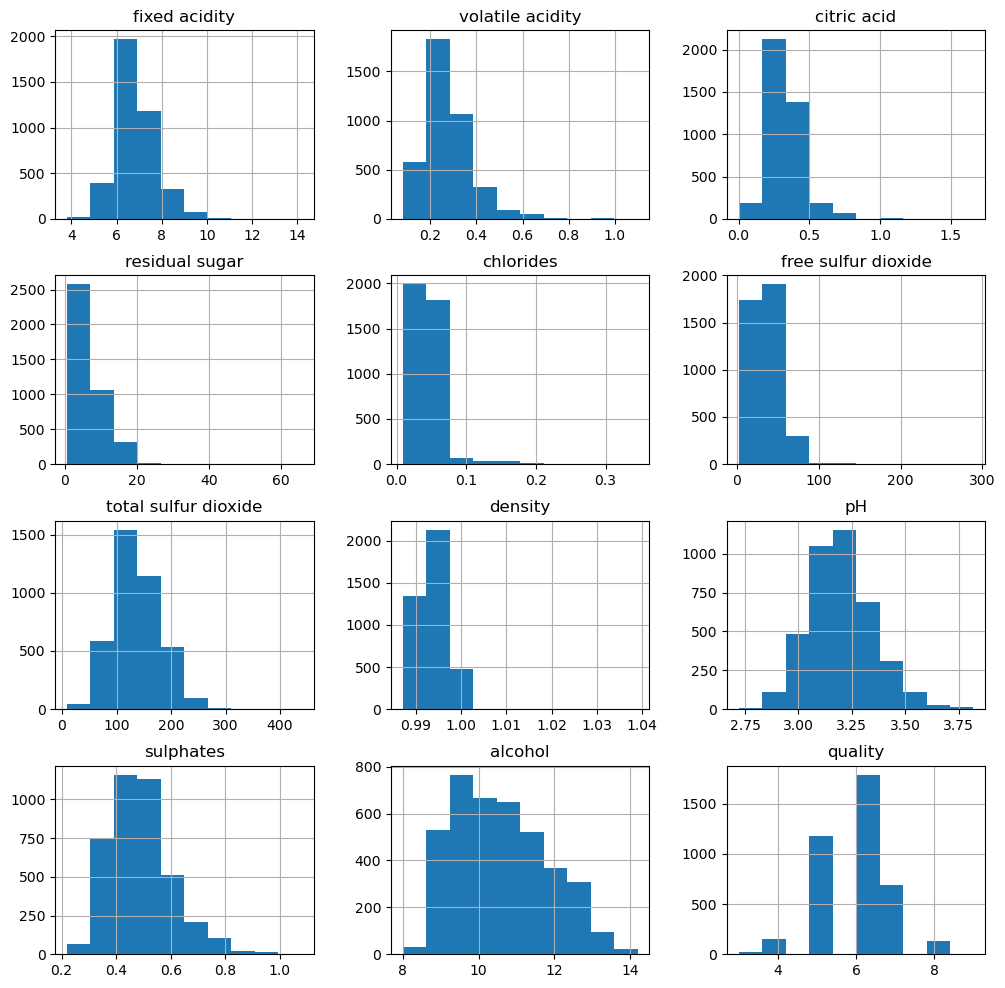

In [10]:
whitewineDF.hist(figsize = (12, 12))
plt.show()

In [11]:
# Z-scroe 기반 이상치 탐지 함수
def find_outlier(column_list, scale = 3, df = whitewineDF):
    for col in column_list:
        mean_value = df[col].mean()
        std_value = df[col].std()
        
        base = scale
        z_data = (df[col] - mean_value) / std_value
        mask = z_data.abs() > scale
        print(f'{col} 특성의 이상치 개수 : {z_data[mask].count()}개\n')

In [12]:
whitewineDF.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [13]:
q_col_list = ['fixed acidity', 'volatile acidity', 'citric acid',
             'residual sugar', 'chlorides', 'free sulfur dioxide',
             'total sulfur dioxide', 'density', 'sulphates']
z_col_list = ['pH', 'alcohol', 'quality']

In [14]:
find_outlier(z_col_list, 3)

pH 특성의 이상치 개수 : 27개

alcohol 특성의 이상치 개수 : 0개

quality 특성의 이상치 개수 : 25개



In [15]:
# quality가 3 또는 9인 것을 이상치로 판단
whitewineDF.quality.value_counts()

quality
6    1788
5    1175
7     689
4     153
8     131
3      20
9       5
Name: count, dtype: int64

In [16]:
# Z-score 기반 이상치 제거 함수
def delete_outlier(column_list, scale = 3, df = whitewineDF):
    del_index_list = []
    for col in column_list:
        mean_value = df[col].mean()
        std_value = df[col].std()
        base = scale
        z_data = (df[col] - mean_value) / std_value
        mask = z_data.abs() > base
        index_list = list(df[mask].index)
        del_index_list += index_list
    
    del_index_list = list(set(del_index_list))
    df = df.drop(del_index_list)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [17]:
# Z-score 기반 이상치 제거 후 확인
whitewineDF = delete_outlier(z_col_list)
whitewineDF.shape

(3909, 12)

In [18]:
# 사분위수 기반 이상치 탐지 함수
def find_outlier2(column_list, scale = 1.5, df = whitewineDF):
    for col in column_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # 이상치로 판단할 기준이 되는 값
        lower = q1 - scale*iqr
        upper = q3 + scale*iqr
        mask = (df[col] < lower) | (df[col] > upper) 
        
        print(f'{col} 특성의 이상치 개수 : {df[col][mask].count()}개\n')

In [19]:
find_outlier2(q_col_list)

fixed acidity 특성의 이상치 개수 : 95개

volatile acidity 특성의 이상치 개수 : 130개

citric acid 특성의 이상치 개수 : 220개

residual sugar 특성의 이상치 개수 : 19개

chlorides 특성의 이상치 개수 : 183개

free sulfur dioxide 특성의 이상치 개수 : 40개

total sulfur dioxide 특성의 이상치 개수 : 11개

density 특성의 이상치 개수 : 6개

sulphates 특성의 이상치 개수 : 96개



In [20]:
# 사분위수 기반 이상치 제거 함수
def delete_outlier2(column_list, scale = 1.5, df = whitewineDF):
    del_index_list = []
    for column in column_list:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - scale*iqr
        upper = q3 + scale*iqr
        mask = (df[column] > upper) | (df[column] < lower)
        index_list = list(df[mask].index)
        del_index_list += index_list
    
    del_index_list = list(set(del_index_list))
    df = df.drop(del_index_list)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [21]:
# 사분위수 기반 이상치 제거 후 확인
whitewineDF = delete_outlier2(q_col_list)
whitewineDF.shape

(3246, 12)

In [22]:
whitewineDF.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.020706,0.253771,0.064134,0.090937,-0.037845,0.065413,0.232534,-0.382471,-0.007951,-0.081668,-0.072452
volatile acidity,-0.020706,1.000000,-0.123304,0.100793,-0.001436,-0.067408,0.139009,0.013434,-0.065249,-0.015217,0.098397,-0.100982
citric acid,0.253771,-0.123304,1.000000,0.038776,0.037115,0.090757,0.100074,0.089331,-0.115286,0.055892,-0.025903,0.025048
residual sugar,0.064134,0.100793,0.038776,1.000000,0.247472,0.360308,0.425615,0.818619,-0.161290,-0.034996,-0.438117,-0.135979
chlorides,0.090937,-0.001436,0.037115,0.247472,1.000000,0.170576,0.371031,0.493901,0.015251,0.086613,-0.538690,-0.308373
free sulfur dioxide,-0.037845,-0.067408,0.090757,0.360308,0.170576,1.000000,0.625117,0.343367,-0.023694,0.037329,-0.261869,0.016662
total sulfur dioxide,0.065413,0.139009,0.100074,0.425615,0.371031,0.625117,1.000000,0.564067,0.019399,0.141458,-0.470203,-0.188756
density,0.232534,0.013434,0.089331,0.818619,0.493901,0.343367,0.564067,1.000000,-0.021323,0.103042,-0.806872,-0.344258
pH,-0.382471,-0.065249,-0.115286,-0.161290,0.015251,-0.023694,0.019399,-0.021323,1.000000,0.126569,0.038904,0.105231
sulphates,-0.007951,-0.015217,0.055892,-0.034996,0.086613,0.037329,0.141458,0.103042,0.126569,1.000000,-0.095154,0.017496


In [23]:
def print_feature(nrows, ncols, df, target, features, corrs):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
corrList = whitewineDF.corr()['quality'][:-1]
corrList

fixed acidity          -0.072452
volatile acidity       -0.100982
citric acid             0.025048
residual sugar         -0.135979
chlorides              -0.308373
free sulfur dioxide     0.016662
total sulfur dioxide   -0.188756
density                -0.344258
pH                      0.105231
sulphates               0.017496
alcohol                 0.460719
Name: quality, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_13588\2208625408.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')


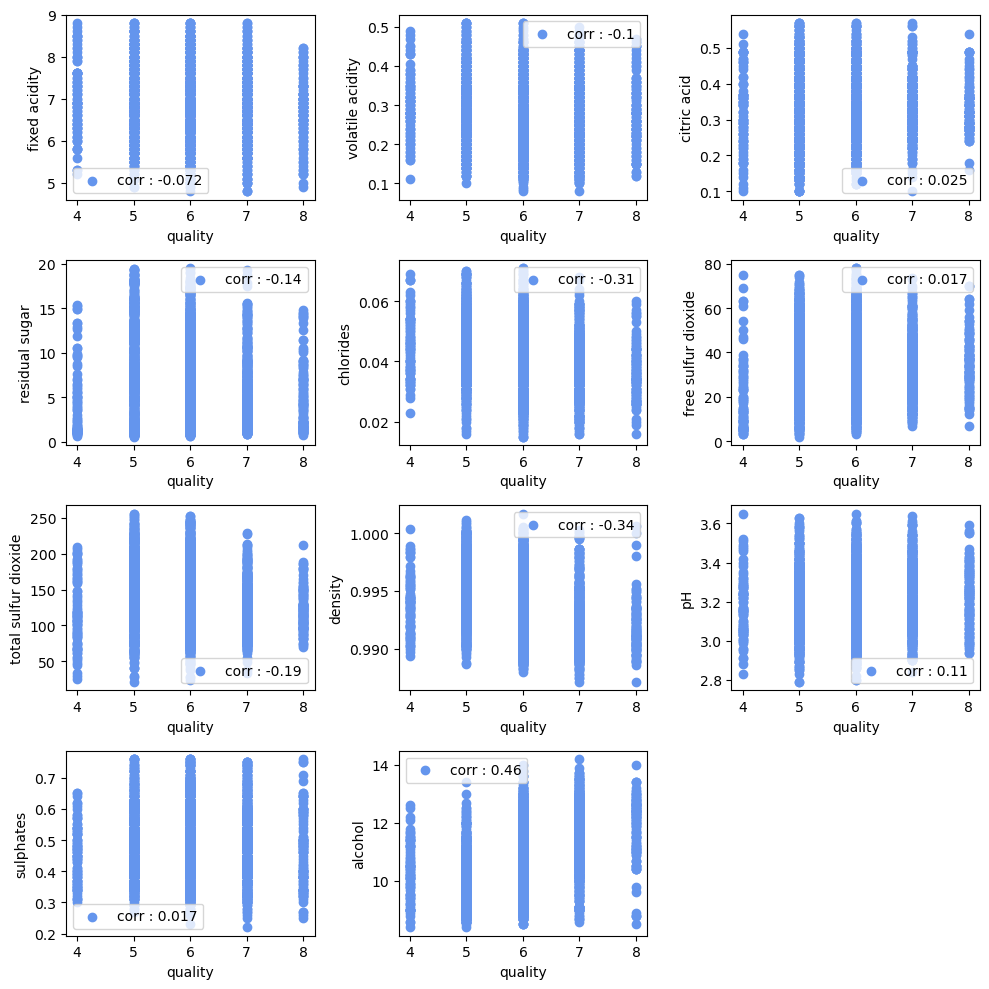

In [25]:
plt.figure(figsize = (10, 10))
print_feature(4, 3, whitewineDF, 'quality', whitewineDF.columns[:-1], corrList)

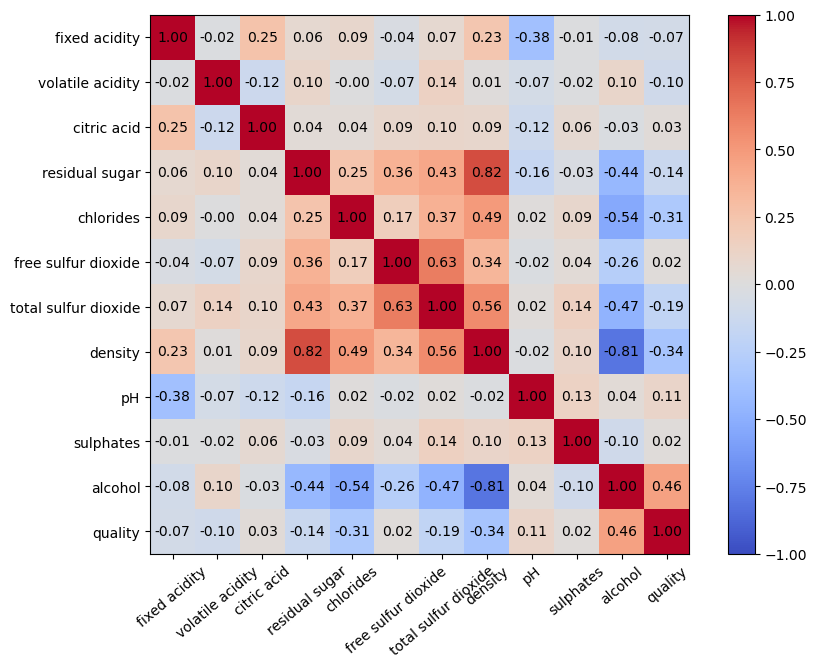

In [26]:
# 상관관계 계산
corr_matrix = whitewineDF.corr()

plt.figure(figsize = (10, 7))
# 히트맵으로 상관계수 표시
plt.imshow(corr_matrix, cmap = 'coolwarm', vmin = -1, vmax = 1)

# x축, y축 눈금 설정
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation = 40)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# 주석 추가
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = f'{corr_matrix.iloc[i, j]:.2f}'
        plt.annotate(text, xy = (j, i), ha = 'center', va = 'center')

# 컬러바 추가
plt.colorbar()
plt.show()

- quality와의 상관계수가 큰 chlorides, density, alcohol 데이터를 구간으로 나눈다.

In [27]:
whitewineDF.quality.value_counts()

quality
6    1530
5     895
7     627
8     110
4      84
Name: count, dtype: int64

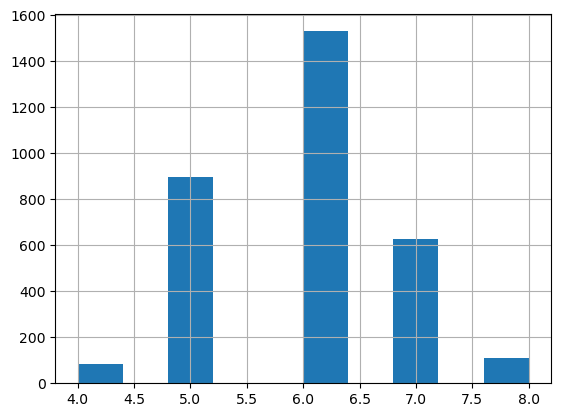

In [28]:
whitewineDF.quality.hist()
plt.show()

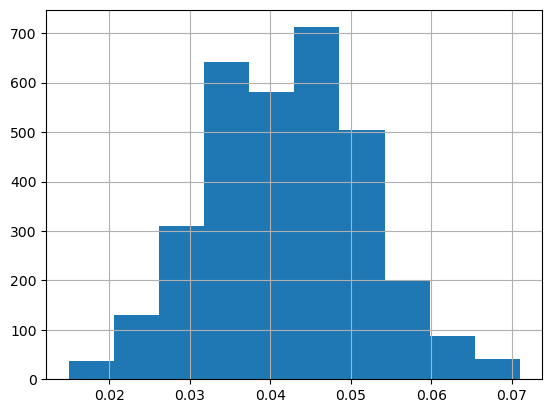

In [29]:
whitewineDF.chlorides.hist()
plt.show()

In [30]:
# 구간으로 나눈 데이터를 원래 데이터에 넣는다.
ind = list(whitewineDF.columns).index('free sulfur dioxide')
new_data = pd.cut(whitewineDF['chlorides'], 5, labels = [50, 40, 30, 20, 10])
whitewineDF.insert(ind, 'chlorides_level', new_data)

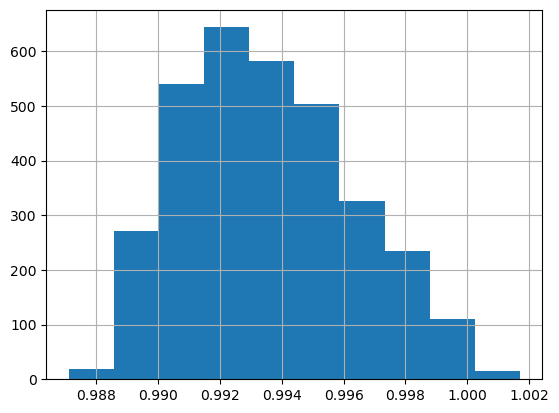

In [31]:
whitewineDF.density.hist()
plt.show()

In [32]:
# 구간으로 나눈 데이터를 원래 데이터에 넣는다.
ind = list(whitewineDF.columns).index('pH')
new_data = pd.cut(whitewineDF['density'], 5, labels = [50, 40, 30, 20, 10])
whitewineDF.insert(ind, 'density_level', new_data)

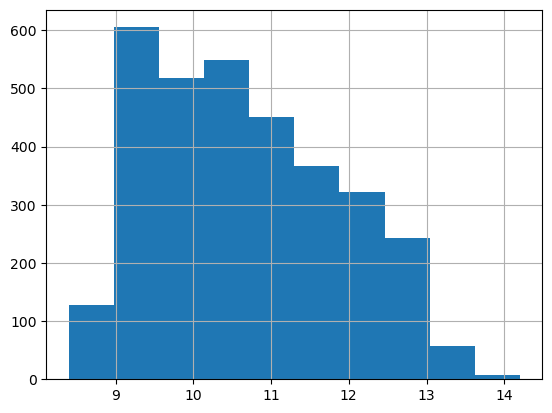

In [33]:
whitewineDF.alcohol.hist()
plt.show()

In [34]:
# 구간으로 나눈 데이터를 원래 데이터에 넣는다.
ind = list(whitewineDF.columns).index('quality')
new_data = pd.cut(whitewineDF['alcohol'], 5, labels = [10, 20, 30, 40, 50])
whitewineDF.insert(ind, 'alcohol_level', new_data)

In [35]:
whitewineDF.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,chlorides_level,free sulfur dioxide,total sulfur dioxide,density,density_level,pH,sulphates,alcohol,alcohol_level,quality
0,6.3,0.3,0.34,1.6,0.049,20,14.0,132.0,0.994,30,3.3,0.49,9.5,10,6


### KNeighborsClassifier로 학습 진행 <hr>

#### 상관계수가 상대적으로 높은 피처 chlorides, density, alcohol 3개로 학습

In [36]:
featureDF = whitewineDF[['chlorides', 'density', 'alcohol']]
targetSR = whitewineDF['quality']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size = 0.2,
                                                    stratify = targetSR)

#### StandardScaler로 데이터 변환

In [38]:
my_scaler = StandardScaler()
my_scaler.fit(X_train)
scaled_X_train = my_scaler.transform(X_train)
scaled_X_test = my_scaler.transform(X_test)

In [39]:
# 학습할 때 경고 메시지 안나오록 하기 위해서 데이터프레임으로 변환
scaled_X_train = pd.DataFrame(scaled_X_train, columns = X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns = X_test.columns)

In [40]:
max_k = 50

train_scoreList = []
test_scoreList = []
for k in range(1, max_k + 1):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    train_scoreList.append(model.score(scaled_X_train, y_train))
    test_scoreList.append(model.score(scaled_X_test, y_test))

max_train_score = max(train_scoreList)
max_test_score = max(test_scoreList)
print(f'train score는 k = {train_scoreList.index(max_train_score) + 1}일 때 train_scoreList의 최댓값 {round(max_train_score, 2)}을 갖는다.\n')
print(f'test score는 k = {test_scoreList.index(max_test_score) + 1}일 때 test_scoreList의 최댓값 {round(max_test_score, 2)}을 갖는다.')

train score는 k = 3일 때 train_scoreList의 최댓값 0.47을 갖는다.

test score는 k = 3일 때 test_scoreList의 최댓값 0.47을 갖는다.


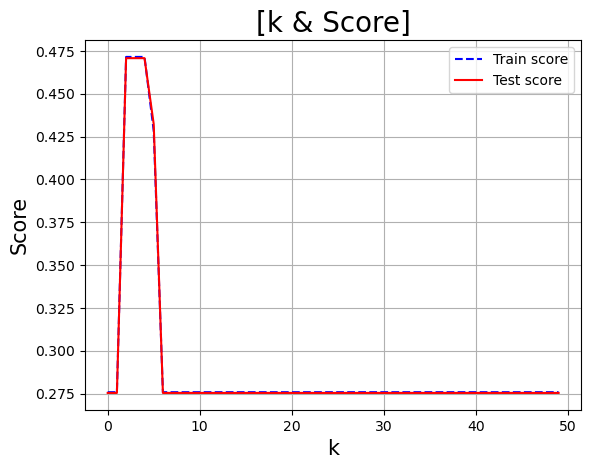

In [41]:
# k에 따른 학습용/테스트용 점수 시각화
plt.plot(train_scoreList, 'b--', label = 'Train score')
plt.plot(test_scoreList, 'r', label = 'Test score')
plt.title('[k & Score]', size = 20)
plt.xlabel('k', size = 15)
plt.ylabel('Score', size = 15)
plt.grid(True)
plt.legend()
plt.show()

#### MinMaxScaler로 데이터 변환

In [42]:
my_scaler = MinMaxScaler()
my_scaler.fit(X_train)
scaled_X_train = my_scaler.transform(X_train)
scaled_X_test = my_scaler.transform(X_test)

In [43]:
# 학습할 때 경고 메시지 안나오록 하기 위해서 데이터프레임으로 변환
scaled_X_train = pd.DataFrame(scaled_X_train, columns = X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns = X_test.columns)

In [44]:
max_k = 50

train_scoreList = []
test_scoreList = []
for k in range(1, max_k + 1):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    train_scoreList.append(model.score(scaled_X_train, y_train))
    test_scoreList.append(model.score(scaled_X_test, y_test))

max_train_score = max(train_scoreList)
max_test_score = max(test_scoreList)
print(f'train score는 k = {train_scoreList.index(max_train_score) + 1}일 때 train_scoreList의 최댓값 {round(max_train_score, 2)}을 갖는다.\n')
print(f'test score는 k = {test_scoreList.index(max_test_score) + 1}일 때 test_scoreList의 최댓값 {round(max_test_score, 2)}을 갖는다.')

train score는 k = 3일 때 train_scoreList의 최댓값 0.47을 갖는다.

test score는 k = 3일 때 test_scoreList의 최댓값 0.47을 갖는다.


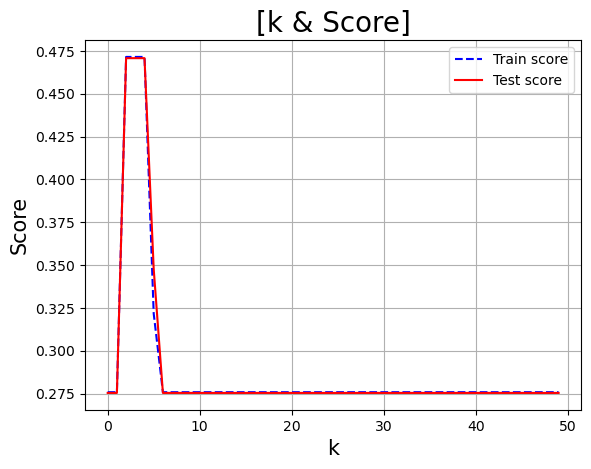

In [45]:
# k에 따른 학습용/테스트용 점수 시각화
plt.plot(train_scoreList, 'b--', label = 'Train score')
plt.plot(test_scoreList, 'r', label = 'Test score')
plt.title('[k & Score]', size = 20)
plt.xlabel('k', size = 15)
plt.ylabel('Score', size = 15)
plt.grid(True)
plt.legend()
plt.show()

#### RobustScaler로 데이터 변환

In [46]:
my_scaler = RobustScaler()
my_scaler.fit(X_train)
scaled_X_train = my_scaler.transform(X_train)
scaled_X_test = my_scaler.transform(X_test)

In [47]:
# 학습할 때 경고 메시지 안나오록 하기 위해서 데이터프레임으로 변환
scaled_X_train = pd.DataFrame(scaled_X_train, columns = X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns = X_test.columns)

In [48]:
max_k = 50

train_scoreList = []
test_scoreList = []
for k in range(1, max_k + 1):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    train_scoreList.append(model.score(scaled_X_train, y_train))
    test_scoreList.append(model.score(scaled_X_test, y_test))

max_train_score = max(train_scoreList)
max_test_score = max(test_scoreList)
print(f'train score는 k = {train_scoreList.index(max_train_score) + 1}일 때 train_scoreList의 최댓값 {round(max_train_score, 2)}을 갖는다.\n')
print(f'test score는 k = {test_scoreList.index(max_test_score) + 1}일 때 test_scoreList의 최댓값 {round(max_test_score, 2)}을 갖는다.')

train score는 k = 3일 때 train_scoreList의 최댓값 0.47을 갖는다.

test score는 k = 3일 때 test_scoreList의 최댓값 0.47을 갖는다.


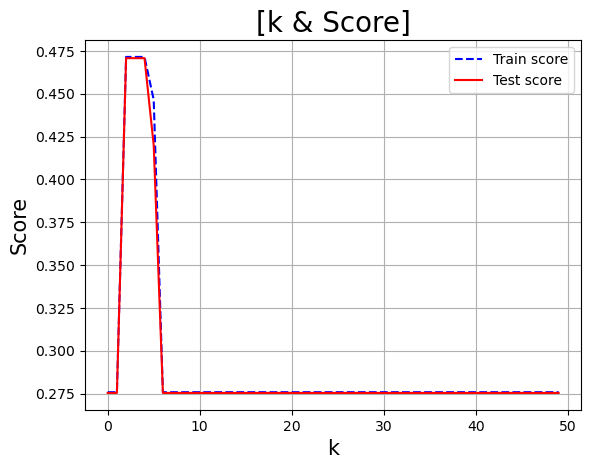

In [49]:
# k에 따른 학습용/테스트용 점수 시각화
plt.plot(train_scoreList, 'b--', label = 'Train score')
plt.plot(test_scoreList, 'r', label = 'Test score')
plt.title('[k & Score]', size = 20)
plt.xlabel('k', size = 15)
plt.ylabel('Score', size = 15)
plt.grid(True)
plt.legend()
plt.show()

In [50]:
whitewineDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,chlorides_level,free sulfur dioxide,total sulfur dioxide,density,density_level,pH,sulphates,alcohol,alcohol_level,quality
0,6.3,0.30,0.34,1.6,0.049,20,14.0,132.0,0.9940,30,3.30,0.49,9.5,10,6
1,8.1,0.28,0.40,6.9,0.050,20,30.0,97.0,0.9951,30,3.26,0.44,10.1,20,6
2,7.2,0.23,0.32,8.5,0.058,20,47.0,186.0,0.9956,30,3.19,0.40,9.9,20,6
3,6.2,0.32,0.16,7.0,0.045,30,30.0,136.0,0.9949,30,3.18,0.47,9.6,20,6
4,8.1,0.22,0.43,1.5,0.044,30,28.0,129.0,0.9938,30,3.22,0.45,11.0,30,6


In [51]:
whitewineDF.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,chlorides_level,free sulfur dioxide,total sulfur dioxide,density,density_level,pH,sulphates,alcohol,alcohol_level,quality
3241,6.2,0.21,0.29,1.6,0.039,30,24.0,92.0,0.99114,40,3.27,0.50,11.2,30,6
3242,6.6,0.32,0.36,8.0,0.047,30,57.0,168.0,0.99490,30,3.15,0.46,9.6,20,5
3243,6.5,0.24,0.19,1.2,0.041,30,30.0,111.0,0.99254,40,2.99,0.46,9.4,10,6
3244,5.5,0.29,0.30,1.1,0.022,50,20.0,110.0,0.98869,50,3.34,0.38,12.8,40,7
3245,6.0,0.21,0.38,0.8,0.020,50,22.0,98.0,0.98941,50,3.26,0.32,11.8,30,6


In [52]:
def train_test_set(features, test_size = 0.2, random_state = 42, file_data = '../DATA/winequality-white.csv'):
    
    # 새로운 피처 3개 추가
    df = pd.read_csv(file_data, sep = ';')
    ind = list(df.columns).index('free sulfur dioxide')
    new_data = pd.cut(df['chlorides'], 5, labels = [50, 40, 30, 20, 10])
    df.insert(ind, 'chlorides_level', new_data)
    
    ind = list(df.columns).index('pH')
    new_data = pd.cut(df['density'], 5, labels = [50, 40, 30, 20, 10])
    df.insert(ind, 'density_level', new_data)
    
    ind = list(df.columns).index('quality')
    new_data = pd.cut(df['alcohol'], 5, labels = [10, 20, 30, 40, 50])
    df.insert(ind, 'alcohol_level', new_data)
    
    featureDF = df[list(features) + ['chlorides_level', 'density_level', 'alcohol_level']]
    targetSR = df['quality']
    X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size = test_size,
                                                    stratify = targetSR,
                                                    random_state = random_state)
    return X_train, X_test, y_train, y_test

In [53]:
def findoptimal(features, my_scaler, test_size = 0.2, max_k = 50, weights = 'uniform', metric = 'minkowski', p = 2, algorithm = 'auto', my_model = KNeighborsClassifier()):
    
    X_train, X_test, y_train, y_test = train_test_set(features)
    for col in features:
        my_scaler.fit(X_train[col].to_frame())
        X_train[col] = my_scaler.transform(X_train[col].to_frame())
        X_test[col] = my_scaler.transform(X_test[col].to_frame())
    scaled_X_train = X_train
    scaled_X_test = X_test
    # print(scaled_X_train)
    # print(scaled_X_test)
    if my_model.__class__ == KNeighborsClassifier:
        train_scoreList = []
        test_scoreList = []
        for k in range(1, max_k + 1):
            model = KNeighborsClassifier(n_neighbors = k)
            model.fit(scaled_X_train, y_train)
            train_scoreList.append(model.score(scaled_X_train, y_train))
            test_scoreList.append(model.score(scaled_X_test, y_test))
        
        # k에 따른 학습용/테스트용 점수 시각화
        # plt.plot(train_scoreList, 'b--', label = 'Train score')
        # plt.plot(test_scoreList, 'r', label = 'Test score')
        # plt.title('k & Score')
        # plt.xlabel('k')
        # plt.ylabel('Score')
        # plt.legend()
        # plt.show()    
    
        # print(f'피처가 {attri1}과 {attri2}일 때 최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')
        max_test_score = max(test_scoreList)
        optimal_k = test_scoreList.index(max_test_score)+1
        model = KNeighborsClassifier(n_neighbors = optimal_k, weights = weights, metric = metric, p = p, algorithm = algorithm)
        model.fit(scaled_X_train, y_train)
        return round(model.score(scaled_X_train, y_train), 2), round(model.score(scaled_X_test, y_test), 2)
        #print(f'train score는 k = {train_scoreList.index(max(train_scoreList))+1}일 때 최댓값 {max(train_scoreList)}을 갖는다.')
        #print(f'test score는 k = {test_scoreList.index(max(test_scoreList))+1}일 때 최댓값 {max(test_scoreList)}을 갖는다.')
    else:   
        my_model.fit(scaled_X_train, y_train)
        return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

In [55]:
['total sulfur dioxide', 'free sulfur dioxide']

['total sulfur dioxide', 'free sulfur dioxide']

In [59]:
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
    print(f"{scaler} => {findoptimal(['chlorides', 'density', 'alcohol', 'total sulfur dioxide', 'free sulfur dioxide'], scaler)}\n")

StandardScaler() => (1.0, 0.59)

MinMaxScaler() => (1.0, 0.59)

RobustScaler() => (1.0, 0.57)



#### 전체 피처로 학습

In [57]:
whitewineDF2 = pd.read_csv(data_file, sep = ';')

In [58]:
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
    print(f"{scaler} => {findoptimal(whitewineDF2.columns[:-1], scaler)}\n")

StandardScaler() => (1.0, 0.59)



KeyboardInterrupt: 

In [ ]:
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
    for weights in ['uniform', 'distance']:
        for p in [1, 2, 3]:
            for metric in ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']: 
                print(f"{scaler} => {findoptimal(whitewineDF.columns[:-1], scaler, weights = weights, metric = metric, p = p, my_model = KNeighborsClassifier())}\n")

StandardScaler() => (1.0, 0.61)

StandardScaler() => (1.0, 0.58)

StandardScaler() => (0.98, 0.57)

StandardScaler() => (1.0, 0.61)

StandardScaler() => (1.0, 0.58)

StandardScaler() => (1.0, 0.61)

StandardScaler() => (1.0, 0.58)

StandardScaler() => (1.0, 0.61)

StandardScaler() => (1.0, 0.58)

StandardScaler() => (0.98, 0.57)

StandardScaler() => (1.0, 0.61)

StandardScaler() => (1.0, 0.58)



KeyboardInterrupt: 